In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

In [8]:
!nvidia-smi

Wed Feb 23 12:18:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
|  0%   25C    P8     8W / 257W |   2324MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
|  0%   

In [3]:
torch.cuda.set_device(device)

In [4]:
from utils import load_cifar10, load_cifar100,load_tinyimagenet

In [5]:
# load cifar10 data
trainloader, testloader = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [24]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
# load dataloader for steal
stealloader,_ = load_cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# load tinyimagenet for outlier exposure
outlier_loader = load_tinyimagenet()

# Train Model

In [10]:
from cifar_models import Net, Net_logit, AttackNet

## Train original network with logit

In [9]:
from utils import train_model_CE

In [10]:
net_logit = Net_logit()

In [11]:
net_optim = optim.Adam(net_logit.parameters(), lr=0.0001)

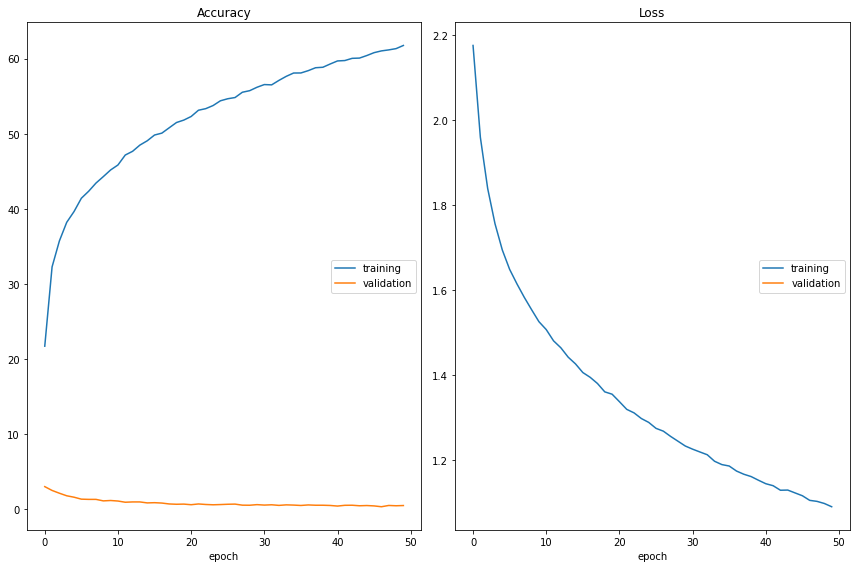

Accuracy
	training         	 (min:   21.690, max:   61.756, cur:   61.756)
	validation       	 (min:    0.300, max:    2.980, cur:    0.460)
Loss
	training         	 (min:    1.091, max:    2.176, cur:    1.091)
	validation       	 (min:      nan, max:      nan, cur:      nan)


In [12]:
net_logit, logit_logs = train_model_CE(net_logit, trainloader, net_optim, device, epochs=50, test_loader = testloader, 
                                       save_dir = "../results",save_model="cifar_logit_net.pth")

### load model

In [17]:
import os
net_logit.load_state_dict(torch.load(os.path.join("../results","cifar_logit_net.pth")))

<All keys matched successfully>

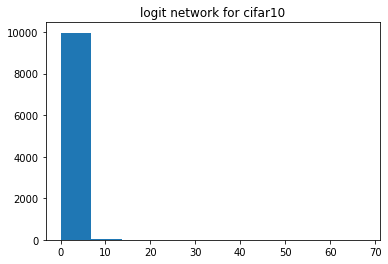

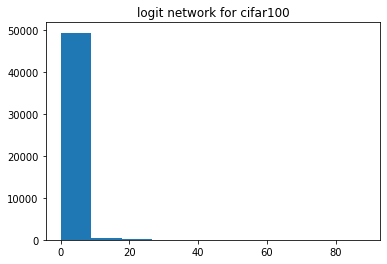

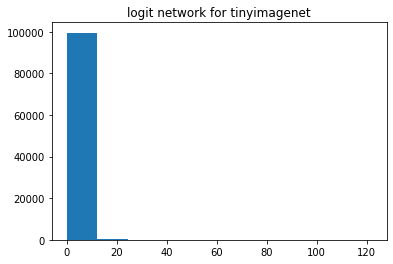

In [18]:
maxclass_hist(testloader, net_logit, device, plt_title="logit network for cifar10")
maxclass_hist(stealloader, net_logit, device, plt_title="logit network for cifar100")
maxclass_hist(outlier_loader, net_logit, device, plt_title="logit network for tinyimagenet")

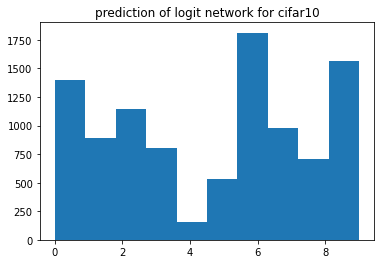

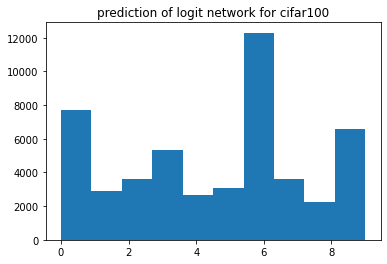

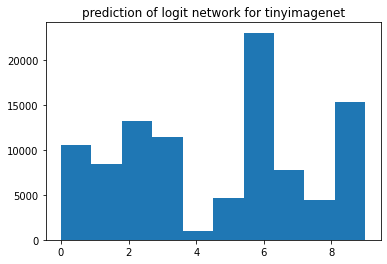

In [19]:
prediction_hist(testloader, net_logit, device, plt_title="prediction of logit network for cifar10")
prediction_hist(stealloader, net_logit, device, plt_title="prediction of logit network for cifar100")
prediction_hist(outlier_loader, net_logit, device, plt_title="prediction of logit network for tinyimagenet")

# Train Fake Net

## Logit + SWAE

In [12]:
from utils import make_st_loader,train_swd_fakenet

In [13]:
fake_logit_swd = Net_logit()

In [14]:
optim_lswd = optim.Adam(fake_logit_swd.parameters(),lr=0.0001)

In [15]:
st_loader = make_st_loader(net_logit, trainloader, device)

NameError: name 'net_logit' is not defined

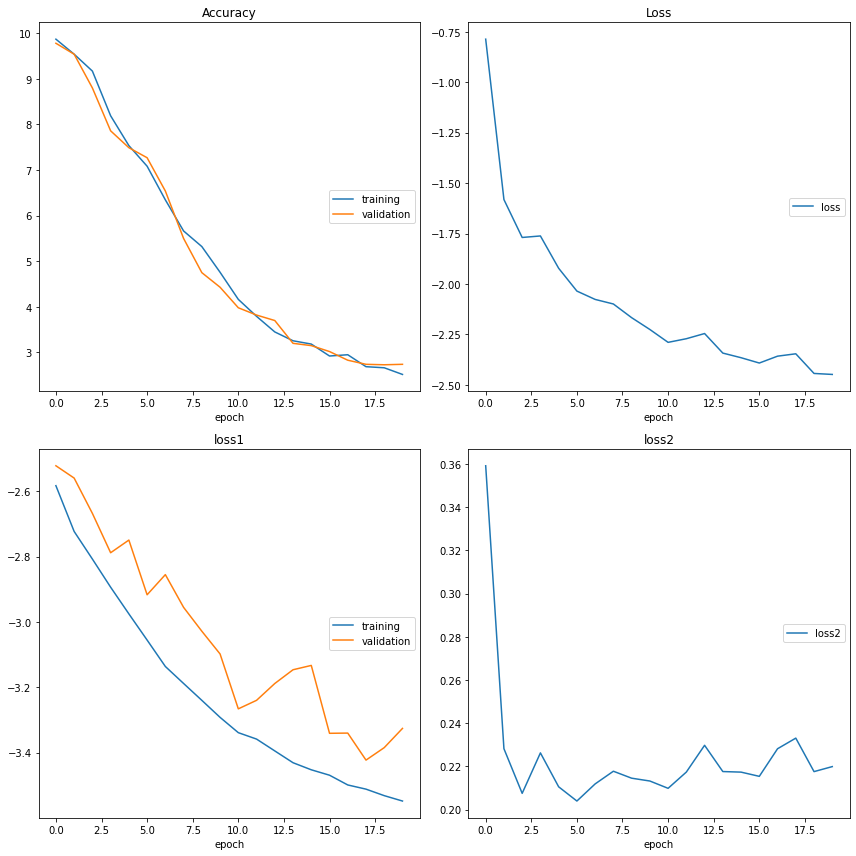

Accuracy
	training         	 (min:    2.518, max:    9.870, cur:    2.518)
	validation       	 (min:    2.730, max:    9.780, cur:    2.740)
Loss
	loss             	 (min:   -2.449, max:   -0.787, cur:   -2.449)
loss1
	training         	 (min:   -3.548, max:   -2.583, cur:   -3.548)
	validation       	 (min:   -3.423, max:   -2.522, cur:   -3.326)
loss2
	loss2            	 (min:    0.204, max:    0.359, cur:    0.220)


In [27]:
fake_logit_swd, flogit_logs = train_swd_fakenet(fake_logit_swd, trainloader, st_loader, optim_lswd, device, epochs=20, 
                                                loss_weights=[-1.0,5.0],test_loader = testloader,
                                                save_dir='../results', save_model="cifar_fake_logit_swd.pth")

### load model

In [21]:
import os
fake_logit_swd = Net_logit()
fake_logit_swd.load_state_dict(torch.load(os.path.join("../results","cifar_fake_logit_swae.pth"),map_location='cpu'))

<All keys matched successfully>

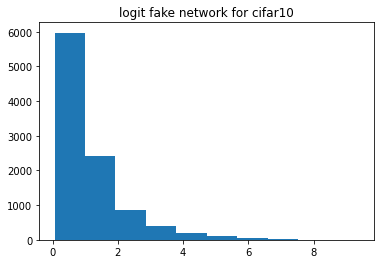

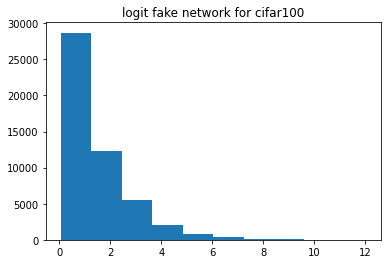

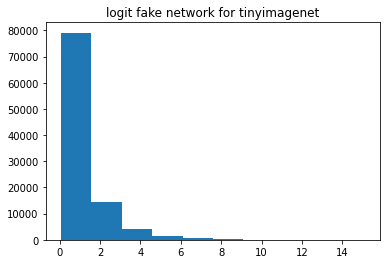

In [28]:
maxclass_hist(testloader, fake_logit_swd, device, plt_title="logit fake network for cifar10")
maxclass_hist(stealloader, fake_logit_swd, device, plt_title="logit fake network for cifar100")
maxclass_hist(outlier_loader, fake_logit_swd, device, plt_title="logit fake network for tinyimagenet")

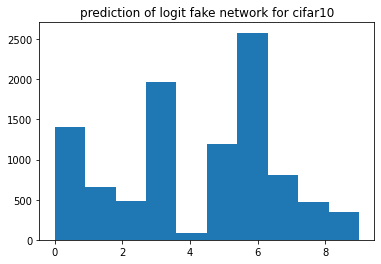

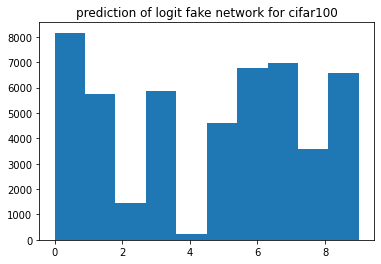

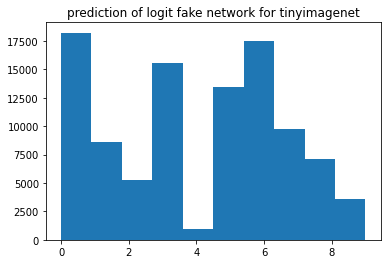

In [29]:
prediction_hist(testloader, fake_logit_swd, device, plt_title="prediction of logit fake network for cifar10")
prediction_hist(stealloader, fake_logit_swd, device, plt_title="prediction of logit fake network for cifar100")
prediction_hist(outlier_loader, fake_logit_swd, device, plt_title="prediction of logit fake network for tinyimagenet")

In [23]:
list(list(fake_logit_swd.modules())[-1].parameters())

[Parameter containing:
 tensor([[ 0.0455, -0.0115, -0.0119,  ...,  0.0624,  0.0421, -0.0010],
         [ 0.0131, -0.0372, -0.0260,  ..., -0.0382,  0.0620, -0.0156],
         [ 0.0362, -0.0506,  0.0359,  ...,  0.0119, -0.0128,  0.0316],
         ...,
         [ 0.0241, -0.0551, -0.0485,  ..., -0.0186, -0.0631,  0.0326],
         [-0.0160, -0.0342, -0.0207,  ...,  0.0435, -0.0333, -0.0281],
         [-0.0534,  0.0536,  0.0445,  ...,  0.0370, -0.0070, -0.0647]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0205,  0.0366,  0.0054,  0.0517, -0.0047, -0.0244,  0.0381,  0.0407,
         -0.0663,  0.0011], requires_grad=True)]